## Reddit r/worldnews: Modeling Results

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import f1_score,precision_score,recall_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import cleaned comments
data_clean_df = pd.read_csv("data/data_clean.csv")
data_clean_df.drop('Unnamed: 0',axis=1,inplace=True)
data_clean = data_clean_df.values.tolist()
data_clean = [val for sublist in data_clean for val in sublist]

In [82]:
# Import full comment df
comments_final = pd.read_pickle("data/comments_final")

### Train-test-split
I first conduct a stratified train-test-split (80%-20%) on the comment data and comment removal indicator.

In [4]:
# Train test split
y = comments_final['Removed'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data_clean,y, test_size = 0.2, stratify = y, random_state = 0)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [5]:
# Remove df to save space
del comments_final

### Modeling Framework
I use stratified k-fold cross validation on my training data for all models and F1, precision, and recall to evaluate model performance. I converted my comment data into term count and term frequency-inverse document frequency (tf-idf) matrices. I use tf-idf for my logistic regression, random forest, and gradient boosting models; and term counts for Naive-Bayes classification. For each model, I compare performance using unigrams vs. bigrams, and no undersampling vs. sampling.

In [6]:
# Evaluation metrics, stratified k-fold cross validation, and models
def custom_eval_metric(y_true, y_pred):   
    f1_score_ = f1_score(y_true,y_pred)
    precision_ = precision_score(y_true,y_pred)
    recall_ = recall_score(y_true,y_pred)
    return f1_score_,precision_,recall_

# Word frequencies
def cross_val_scores_freq(X_train, y_train, num_folds, model, undersampling=False, bigrams=False):      
    strat_kf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    test_f1 = np.empty(num_folds)
    test_precision = np.empty(num_folds)
    test_recall = np.empty(num_folds)
    
    index = 0
    model = model
     
    for train, test in strat_kf.split(X_train,y_train):        
        x_train_, x_test_ = X_train[train], X_train[test]
        y_train_, y_test_ = y_train[train], y_train[test]
        
        if undersampling:
            undersample = RandomUnderSampler(sampling_strategy='majority') 
            x_train_, y_train_ = undersample.fit_resample(np.array(x_train_).reshape(-1,1), y_train_)         
            x_train_ = x_train_.tolist()
            x_train_ = [val for sublist in x_train_ for val in sublist]
        if bigrams:
            tfidf = TfidfVectorizer(ngram_range=(1,2))
            x_train_ = tfidf.fit_transform(np.array(x_train_))
            x_test_ = tfidf.transform(x_test_)
        else:       
            tfidf = TfidfVectorizer()
            x_train_ = tfidf.fit_transform(np.array(x_train_))
            x_test_ = tfidf.transform(x_test_)
        
        model.fit(x_train_, y_train_)

        pred_test = model.predict(x_test_)
        test_f1[index],test_precision[index],test_recall[index] = custom_eval_metric(y_test_,pred_test)
        index += 1    
    return np.mean(test_f1), np.mean(test_precision), np.mean(test_recall)

# Word Counts
def cross_val_scores_count(X_train, y_train, num_folds, model, undersampling=False, bigrams=False):      
    strat_kf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    test_f1 = np.empty(num_folds)
    test_precision = np.empty(num_folds)
    test_recall = np.empty(num_folds)
    
    index = 0
    model = model
     
    for train, test in strat_kf.split(X_train,y_train):        
        x_train_, x_test_ = X_train[train], X_train[test]
        y_train_, y_test_ = y_train[train], y_train[test]
        
        if undersampling:
            undersample = RandomUnderSampler(sampling_strategy='majority') 
            x_train_, y_train_ = undersample.fit_resample(np.array(x_train_).reshape(-1,1), y_train_)         

            x_train_ = x_train_.tolist()
            x_train_ = [val for sublist in x_train_ for val in sublist]
        if bigrams:
            bow = CountVectorizer(ngram_range=(1,2))
            x_train_ = bow.fit_transform(np.array(x_train_))
            x_test_ = bow.transform(x_test_)
        else:       
            bow = CountVectorizer()
            x_train_ = bow.fit_transform(np.array(x_train_))
            x_test_ = bow.transform(x_test_)
        
        model.fit(x_train_, y_train_)

        pred_test = model.predict(x_test_)
        test_f1[index],test_precision[index],test_recall[index] = custom_eval_metric(y_test_,pred_test)
        index += 1    
    return np.mean(test_f1), np.mean(test_precision), np.mean(test_recall)



#### Unigrams & No Undersampling
My "original" set of models uses unigrams (single words) and no undersampling.

In [7]:
# Unigrams & No Undersampling

# Baseline model
f1_score_,precision_,recall_ = cross_val_scores_freq(X_train, y_train, 5, DummyClassifier(strategy="stratified"))

# Logistic Regression
f1_score_lr,precision_lr,recall_lr = cross_val_scores_freq(X_train, y_train, 5, LogisticRegression(random_state=0))

# Random Forest
f1_score_rf,precision_rf,recall_rf = cross_val_scores_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0))

# Gradient Boosting
f1_score_gb,precision_gb,recall_gb = cross_val_scores_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0))

# Naive Bayes
f1_score_nb,precision_nb,recall_nb = cross_val_scores_count(X_train, y_train, 5, ComplementNB())



In [8]:
f1_list_orig = [f1_score_, f1_score_lr, f1_score_rf, f1_score_gb, f1_score_nb]
precision_list_orig = [precision_, precision_lr, precision_rf, precision_gb, precision_nb]
recall_list_orig = [recall_, recall_lr, recall_rf, recall_gb, recall_nb]

In [57]:
print(f'F1 Scores: Unigrams & No Undersampling')
print(f'Baseline: {f1_score_:.4f}')
print(f'Logistic Regression: {f1_score_lr:.4f}')
print(f'Random Forest: {f1_score_rf:.4f}')
print(f'Gradient Boosting: {f1_score_gb:.4f}')
print(f'Naive-Bayes: {f1_score_nb:.4f}')

F1 Scores: Unigrams & No Undersampling
Baseline: 0.0302
Logistic Regression: 0.1281
Random Forest: 0.1963
Gradient Boosting: 0.0082
Naive-Bayes: 0.1089


#### Unigrams & Undersampling
I then try out an undersampling approach, where I randomly remove samples from the target majority ("intact comments") class until the class distribution becomes equal.

In [10]:
# Unigrams & Undersampling

# Baseline model
f1_score_bal,precision_bal,recall_bal = cross_val_scores_freq(X_train, y_train, 5, DummyClassifier(strategy="stratified"),undersampling=True)

# Logistic Regression
f1_score_lr_bal,precision_lr_bal,recall_lr_bal = cross_val_scores_freq(X_train, y_train, 5, LogisticRegression(random_state=0),undersampling=True)

# Random Forest
f1_score_rf_bal,precision_rf_bal,recall_rf_bal = cross_val_scores_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5,random_state=0),undersampling=True)

# Gradient Boosting
f1_score_gb_bal,precision_gb_bal,recall_gb_bal = cross_val_scores_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5,random_state=0),undersampling=True)

# Naive Bayes
f1_score_nb_bal,precision_nb_bal,recall_nb_bal = cross_val_scores_count(X_train, y_train, 5, ComplementNB(),undersampling=True)


In [11]:
f1_list_bal = [f1_score_bal, f1_score_lr_bal, f1_score_rf_bal, f1_score_gb_bal, f1_score_nb_bal]
precision_list_bal = [precision_bal, precision_lr_bal, precision_rf_bal, precision_gb_bal, precision_nb_bal]
recall_list_bal = [recall_bal, recall_lr_bal, recall_rf_bal, recall_gb_bal, recall_nb_bal]

In [58]:
print(f'F1 Scores: Unigrams & Undersampling')
print(f'Baseline: {f1_score_bal:.4f}')
print(f'Logistic Regression: {f1_score_lr_bal:.4f}')
print(f'Random Forest: {f1_score_rf_bal:.4f}')
print(f'Gradient Boosting: {f1_score_gb_bal:.4f}')
print(f'Naive-Bayes: {f1_score_nb_bal:.4f}')


F1 Scores: Unigrams & Undersampling
Baseline: 0.0570
Logistic Regression: 0.1406
Random Forest: 0.1013
Gradient Boosting: 0.1470
Naive-Bayes: 0.1148


#### Bigrams & No Undersampling
I next experiment with bigrams (word pairings) instead of single words. 

In [12]:
# Bigrams

# Baseline model
f1_score_bi,precision_bi,recall_bi = cross_val_scores_freq(X_train, y_train, 5, DummyClassifier(strategy="stratified", random_state=0), bigrams=True)

# Logistic Regression
f1_score_lr_bi,precision_lr_bi,recall_lr_bi = cross_val_scores_freq(X_train, y_train, 5, LogisticRegression(random_state=0), bigrams=True)

# Random Forest
f1_score_rf_bi,precision_rf_bi,recall_rf_bi = cross_val_scores_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0), bigrams=True)

# Gradient Boosting
f1_score_gb_bi,precision_gb_bi,recall_gb_bi = cross_val_scores_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0), bigrams=True)

# Naive Bayes
f1_score_nb_bi,precision_nb_bi,recall_nb_bi = cross_val_scores_count(X_train, y_train, 5, ComplementNB(), bigrams=True)

In [13]:
f1_list_bi = [f1_score_bi, f1_score_lr_bi, f1_score_rf_bi, f1_score_gb_bi, f1_score_nb_bi]
precision_list_bi = [precision_bi, precision_lr_bi, precision_rf_bi, precision_gb_bi, precision_nb_bi]
recall_list_bi= [recall_bi, recall_lr_bi, recall_rf_bi, recall_gb_bi, recall_nb_bi]

In [59]:
print(f'F1 Scores: Bigrams & No Undersampling')
print(f'Baseline: {f1_score_bi:.4f}')
print(f'Logistic Regression: {f1_score_lr_bi:.4f}')
print(f'Random Forest: {f1_score_rf_bi:.4f}')
print(f'Gradient Boosting: {f1_score_gb_bi:.4f}')
print(f'Naive-Bayes: {f1_score_nb_bi:.4f}')

F1 Scores: Bigrams & No Undersampling
Baseline: 0.0294
Logistic Regression: 0.1178
Random Forest: 0.2027
Gradient Boosting: 0.0163
Naive-Bayes: 0.0652


#### Bigrams & Undersampling
Lastly, I look at the effect of using both bigrams and undersampling.

In [15]:
# Bigrams & Undersampling

# Baseline model
f1_score_bi_u,precision_bi_u,recall_bi_u = cross_val_scores_freq(X_train, y_train, 5, DummyClassifier(strategy="stratified", random_state=0), bigrams=True, undersampling=True)

# Logistic Regression
f1_score_lr_bi_u,precision_lr_bi_u,recall_lr_bi_u = cross_val_scores_freq(X_train, y_train, 5, LogisticRegression(random_state=0), bigrams=True, undersampling=True)

# Random Forest
f1_score_rf_bi_u,precision_rf_bi_u,recall_rf_bi_u = cross_val_scores_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0), bigrams=True, undersampling=True)

# Gradient Boosting
f1_score_gb_bi_u,precision_gb_bi_u,recall_gb_bi_u = cross_val_scores_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0), bigrams=True, undersampling=True)

# Naive Bayes
f1_score_nb_bi_u,precision_nb_bi_u,recall_nb_bi_u = cross_val_scores_count(X_train, y_train, 5, ComplementNB(), bigrams=True, undersampling=True)


In [16]:
f1_list_bi_u = [f1_score_bi_u, f1_score_lr_bi_u, f1_score_rf_bi_u, f1_score_gb_bi_u, f1_score_nb_bi_u]
precision_list_bi_u = [precision_bi_u, precision_lr_bi_u, precision_rf_bi_u, precision_gb_bi_u, precision_nb_bi_u]
recall_list_bi_u = [recall_bi_u, recall_lr_bi_u, recall_rf_bi_u, recall_gb_bi_u, recall_nb_bi_u]

In [60]:
print(f'F1 Scores: Bigrams & Undersampling')
print(f'Baseline: {f1_score_bi_u:.4f}')
print(f'Logistic Regression: {f1_score_lr_bi_u:.4f}')
print(f'Random Forest: {f1_score_rf_bi_u:.4f}')
print(f'Gradient Boosting: {f1_score_gb_bi_u:.4f}')
print(f'Naive-Bayes: {f1_score_nb_bi_u:.4f}')

F1 Scores: Bigrams & Undersampling
Baseline: 0.0569
Logistic Regression: 0.1373
Random Forest: 0.0950
Gradient Boosting: 0.1478
Naive-Bayes: 0.1123


In [81]:
print(f'Best model is random forest using bigrams and no undersampling')
print(f'F1: {f1_score_rf_bi:.4f}')
print(f'precision: {precision_rf_bi:.4f}')
print(f'recall: {recall_rf_bi:.4f}')


Best model is random forest using bigrams and no undersampling
F1: 0.2027
precision: 0.4814
recall: 0.1285


### Modeling Results

As we see above, the model that yields the highest F1 score is Random Forest using bigrams and no undersampling, with an F1 score of 0.203, precision of 0.481, and recall of 0.129.

In [84]:
# Plot modeling results
def plot_results(barwidth, f1_list, precision_list, recall_list, title):
    
    barwidth = barwidth

    r1 = np.arange(len(f1_list))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]

    plt.bar(r1, f1_list, color='midnightblue', width=barwidth, edgecolor='white', label='F1 Score')
    plt.bar(r2, precision_list, color='tomato', width=barwidth, edgecolor='white', label='Precision')
    plt.bar(r3, recall_list, color='gold', width=barwidth, edgecolor='white', label='Recall')

    plt.xticks([r + barwidth for r in range(len(f1_list))], ['Baseline', 'Logistic\nRegression', 'Random\nForest', 'Gradient\nBoosting', 'Naive-Bayes'])
    plt.title(title)
    
    plt.legend()
    plt.savefig(f'imgs/{title}.png')
    plt.show()


F1, precision, and recall scores for all models and approaches are graphed below. For the no undersampling approach, we see high precision and low recall, but for the undersampling approach, we see low precision and high recall.

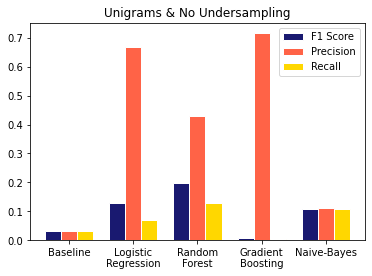

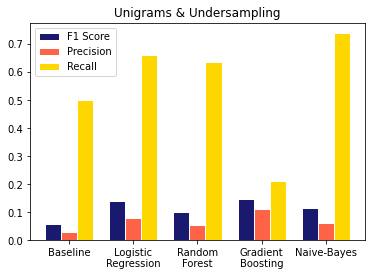

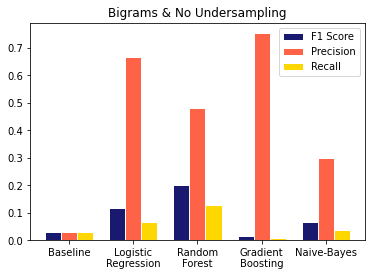

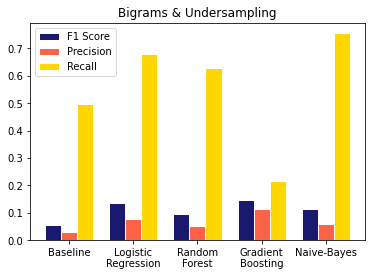

In [73]:
plot_results(0.25, f1_list_orig, precision_list_orig, recall_list_orig, "Unigrams & No Undersampling")
plot_results(0.25, f1_list_bal, precision_list_bal, recall_list_bal, "Unigrams & Undersampling")
plot_results(0.25, f1_list_bi, precision_list_bi, recall_list_bi, "Bigrams & No Undersampling")
plot_results(0.25, f1_list_bi_u, precision_list_bi_u, recall_list_bi_u, "Bigrams & Undersampling")



### Optimize Precision-Recall Tradeoff (F1 Scores)
Using the same modeling framework as above, I next evaluate model performance across a range of decision thresholds to maximize F1 scores across all models and approaches.  

In [21]:
# Tune precision-recall tradeoff to maximize F1 scores 

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# Word frequencies
def model_thresh_freq(X_train, y_train, num_folds, model, undersampling=False, bigrams=False):
       
    strat_kf = StratifiedKFold(n_splits=5, shuffle=True)   
    thresholds = np.arange(0, 1, 0.001)
    
    test_f1 = np.empty((num_folds,thresholds.shape[0]))
    test_precision = np.empty((num_folds,thresholds.shape[0]))
    test_recall = np.empty((num_folds,thresholds.shape[0]))
    
    index = 0
    model = model
    best_thresh = list()
        
    for train, test in strat_kf.split(X_train,y_train):        
        x_train_, x_test_ = X_train[train], X_train[test]
        y_train_, y_test_ = y_train[train], y_train[test]
        
        if undersampling:
            undersample = RandomUnderSampler(sampling_strategy='majority') 
            x_train_, y_train_ = undersample.fit_resample(np.array(x_train_).reshape(-1,1), y_train_)         
            x_train_ = x_train_.tolist()
            x_train_ = [val for sublist in x_train_ for val in sublist]     
        if bigrams:
            tfidf = TfidfVectorizer(ngram_range=(1,2))
            x_train_ = tfidf.fit_transform(np.array(x_train_))
            x_test_ = tfidf.transform(x_test_)
        else:       
            tfidf = TfidfVectorizer()
            x_train_ = tfidf.fit_transform(np.array(x_train_))
            x_test_ = tfidf.transform(x_test_)       

        model.fit(x_train_, y_train_)      
        yhat = model.predict_proba(x_test_)
        probs = yhat[:, 1]
        
        scores = [f1_score(y_test_, to_labels(probs, t)) for t in thresholds]
        precision = [precision_score(y_test_, to_labels(probs, t)) for t in thresholds]
        recall = [recall_score(y_test_, to_labels(probs, t)) for t in thresholds]
        
        test_f1[index] = scores
        test_precision[index] = precision
        test_recall[index] = recall               
        index += 1    
        
    f1_ = np.average(test_f1,axis=0)
    precision_ = np.average(test_precision,axis=0)
    recall_ = np.average(test_recall,axis=0)
    
    ix = np.argmax(f1_)
    ip = np.argmax(precision_)
    ir = np.argmax(recall_)
        
    return f1_[ix], precision_[ix], recall_[ix], thresholds[ix], f1_, thresholds 

# Word counts
def model_thresh_count(X_train, y_train, num_folds, model, undersampling=False, bigrams=False):
    strat_kf = StratifiedKFold(n_splits=5, shuffle=True)    
    thresholds = np.arange(0, 1, 0.001)
    
    test_f1 = np.empty((num_folds,thresholds.shape[0]))
    test_precision = np.empty((num_folds,thresholds.shape[0]))
    test_recall = np.empty((num_folds,thresholds.shape[0]))
    
    index = 0
    model = model
    best_thresh = list()
        
    for train, test in strat_kf.split(X_train,y_train):        
        x_train_, x_test_ = X_train[train], X_train[test]
        y_train_, y_test_ = y_train[train], y_train[test]
        
        if undersampling:
            undersample = RandomUnderSampler(sampling_strategy='majority') 
            x_train_, y_train_ = undersample.fit_resample(np.array(x_train_).reshape(-1,1), y_train_)         
            x_train_ = x_train_.tolist()
            x_train_ = [val for sublist in x_train_ for val in sublist]
        if bigrams:
            bow = CountVectorizer(ngram_range=(1,2))
            x_train_ = bow.fit_transform(np.array(x_train_))
            x_test_ = bow.transform(x_test_)
        else:       
            bow = CountVectorizer()
            x_train_ = bow.fit_transform(np.array(x_train_))
            x_test_ = bow.transform(x_test_)
        
        model.fit(x_train_, y_train_)
        yhat = model.predict_proba(x_test_)
        probs = yhat[:, 1]
        
        scores = [f1_score(y_test_, to_labels(probs, t)) for t in thresholds]
        precision = [precision_score(y_test_, to_labels(probs, t)) for t in thresholds]
        recall = [recall_score(y_test_, to_labels(probs, t)) for t in thresholds]
        
        test_f1[index] = scores
        test_precision[index] = precision
        test_recall[index] = recall              
        index += 1 
    
    f1_ = np.average(test_f1,axis=0)
    precision_ = np.average(test_precision,axis=0)
    recall_ = np.average(test_recall,axis=0)
    
    ix = np.argmax(f1_)
    ip = np.argmax(precision_)
    ir = np.argmax(recall_)
        
    return f1_[ix], precision_[ix], recall_[ix], thresholds[ix], f1_, thresholds 


#### Unigrams & No Undersampling

In [22]:
# Tuned Results: Unigrams & No Undersampling
best_f1_lr,best_precision_lr,best_recall_lr,best_thresh_lr,f1_lr,thresh_lr = model_thresh_freq(X_train, y_train, 5, LogisticRegression(random_state=0))
best_f1_rf,best_precision_rf,best_recall_rf,best_thresh_rf,f1_rf,thresh_rf = model_thresh_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0))
best_f1_gb,best_precision_gb,best_recall_gb,best_thresh_gb,f1_gb,thresh_gb = model_thresh_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0))
best_f1_nb,best_precision_nb,best_recall_nb,best_thresh_nb,f1_nb,thresh_nb = model_thresh_count(X_train, y_train, 5, ComplementNB())

In [74]:
print(f'Tuned F1 Scores: Unigrams & No Undersampling')
print(f'Logistic Regression: {best_f1_lr:.4f}')
print(f'Random Forest: {best_f1_rf:.4f}')
print(f'Gradient Boosting: {best_f1_gb:.4f}')
print(f'Naive-Bayes: {best_f1_nb:.4f}')

Tuned F1 Scores: Unigrams & No Undersampling
Logistic Regression: 0.2937
Random Forest: 0.2409
Gradient Boosting: 0.1695
Naive-Bayes: 0.1883


#### Bigrams & No Undersampling

In [24]:
# Tuned Results: Bigrams
best_f1_lr_bi,best_precision_lr_bi,best_recall_lr_bi,best_thresh_lr_bi,f1_lr_bi,thresh_lr_bi = model_thresh_freq(X_train, y_train, 5, LogisticRegression(random_state=0),bigrams=True)
best_f1_rf_bi,best_precision_rf_bi,best_recall_rf_bi,best_thresh_rf_bi,f1_rf_bi,thresh_rf_bi = model_thresh_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0),bigrams=True)
best_f1_gb_bi,best_precision_gb_bi,best_recall_gb_bi,best_thresh_gb_bi,f1_gb_bi,thresh_gb_bi = model_thresh_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0),bigrams=True)
best_f1_nb_bi,best_precision_nb_bi,best_recall_nb_bi,best_thresh_nb_bi,f1_nb_bi,thresh_nb_bi = model_thresh_count(X_train, y_train, 5, ComplementNB(),bigrams=True)


In [75]:
print(f'Tuned F1 Scores: Bigrams & No Undersampling')
print(f'Logistic Regression: {best_f1_lr_bi:.4f}')
print(f'Random Forest: {best_f1_rf_bi:.4f}')
print(f'Gradient Boosting: {best_f1_gb_bi:.4f}')
print(f'Naive-Bayes: {best_f1_nb_bi:.4f}')

Tuned F1 Scores: Bigrams & No Undersampling
Logistic Regression: 0.2975
Random Forest: 0.2585
Gradient Boosting: 0.1709
Naive-Bayes: 0.0993


#### Unigrams & Undersampling

In [27]:
# Tuned Results: Undersampling
best_f1_lr_u,best_precision_lr_u,best_recall_lr_u,best_thresh_lr_u,f1_lr_u,thresh_lr_u = model_thresh_freq(X_train, y_train, 5, LogisticRegression(random_state=0),undersampling=True)
best_f1_rf_u,best_precision_rf_u,best_recall_rf_u,best_thresh_rf_u,f1_rf_u,thresh_rf_u = model_thresh_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0),undersampling=True)
best_f1_gb_u,best_precision_gb_u,best_recall_gb_u,best_thresh_gb_u,f1_gb_u,thresh_gb_u = model_thresh_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0),undersampling=True)
best_f1_nb_u,best_precision_nb_u,best_recall_nb_u,best_thresh_nb_u,f1_nb_u,thresh_nb_u = model_thresh_count(X_train, y_train, 5, ComplementNB(),undersampling=True)

In [76]:
print(f'Tuned F1 Scores: Unigrams & Undersampling')
print(f'Logistic Regression: {best_f1_lr_u:.4f}')
print(f'Random Forest: {best_f1_rf_u:.4f}')
print(f'Gradient Boosting: {best_f1_gb_u:.4f}')
print(f'Naive-Bayes: {best_f1_nb_u:.4f}')

Tuned F1 Scores: Unigrams & Undersampling
Logistic Regression: 0.2491
Random Forest: 0.1548
Gradient Boosting: 0.1550
Naive-Bayes: 0.2474


#### Bigrams & Undersampling

In [29]:
# Tuned Results: Bigrams & Undersampling
best_f1_lr_bi_u,best_precision_lr_bi_u,best_recall_lr_bi_u,best_thresh_lr_bi_u,f1_lr_bi_u,thresh_lr_bi_u = model_thresh_freq(X_train, y_train, 5, LogisticRegression(random_state=0),bigrams=True,undersampling=True)
best_f1_rf_bi_u,best_precision_rf_bi_u,best_recall_rf_bi_u,best_thresh_rf_bi_u,f1_rf_bi_u,thresh_rf_bi_u = model_thresh_freq(X_train, y_train, 5, RandomForestClassifier(n_estimators=5, random_state=0),bigrams=True,undersampling=True)
best_f1_gb_bi_u,best_precision_gb_bi_u,best_recall_gb_bi_u,best_thresh_gb_bi_u,f1_gb_bi_u,thresh_gb_bi_u = model_thresh_freq(X_train, y_train, 5, GradientBoostingClassifier(n_estimators=5, random_state=0),bigrams=True,undersampling=True)
best_f1_nb_bi_u,best_precision_nb_bi_u,best_recall_nb_bi_u,best_thresh_nb_bi_u,f1_nb_bi_u,thresh_nb_bi_u = model_thresh_count(X_train, y_train, 5, ComplementNB(),bigrams=True,undersampling=True)


In [77]:
print(f'Tuned F1 Scores: Bigrams & Undersampling')
print(f'Logistic Regression: {best_f1_lr_bi_u:.4f}')
print(f'Random Forest: {best_f1_rf_bi_u:.4f}')
print(f'Gradient Boosting: {best_f1_gb_bi_u:.4f}')
print(f'Naive-Bayes: {best_f1_nb_bi_u:.4f}')

Tuned F1 Scores: Bigrams & Undersampling
Logistic Regression: 0.2412
Random Forest: 0.1373
Gradient Boosting: 0.1597
Naive-Bayes: 0.2556


In [86]:
print(f'Best tuned model is logistic regression using bigrams and no undersampling')
print(f'F1: {best_f1_lr_bi:.4f}')
print(f'precision: {best_precision_lr_bi:.4f}')
print(f'recall: {best_recall_lr_bi:.4f}')
print(f'threshold: {best_thresh_lr_bi:.4f}')

Best tuned model is logistic regression using bigrams and no undersampling
F1: 0.2975
precision: 0.2811
recall: 0.3159
threshold: 0.1030


### Optimized Modeling Results
As we see above, the model that yields the highest F1 score is logistic regression using bigrams and no undersampling, with an F1 score of 0.298, precision of 0.281, recall of 0.316, and decision threshold of 0.103.

In [71]:
# Plot tuned model results
def plot_tuned_results(threshlr,threshrf,threshgb,threshnb,f1_lr,f1_rf,f1_gb,f1_nb,title):  
    plt.plot(threshlr,f1_lr,label="Logistic Regression",color='darkblue')
    plt.plot(threshrf,f1_rf,label="Random Forest")
    plt.plot(threshgb,f1_gb,label="Gradient Boosting")
    plt.plot(threshnb,f1_nb,label="Naive Bayes",color='gold')
    
    plt.xlabel("Decision Thresholds")
    plt.ylabel("F1 Score")
    
    plt.title(title)
    plt.legend()
    plt.savefig(f'imgs/Tuned Results: {title}.png')
    plt.show()

F1 scores for all models, approaches, and decision thresholds are graphed below.

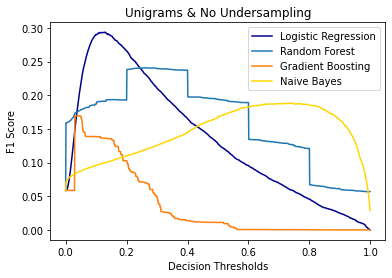

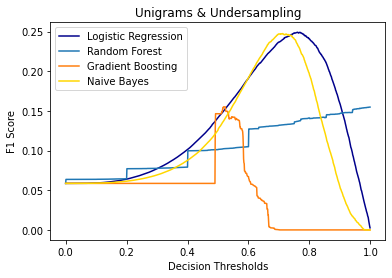

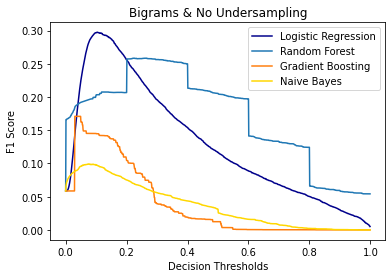

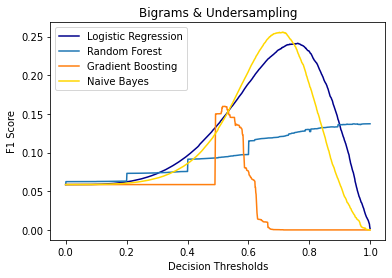

In [72]:
plot_tuned_results(thresh_lr,thresh_rf,thresh_gb,thresh_nb,f1_lr,f1_rf,f1_gb,f1_nb,"Unigrams & No Undersampling")
plot_tuned_results(thresh_lr_u,thresh_rf_u,thresh_gb_u,thresh_nb_u,f1_lr_u,f1_rf_u,f1_gb_u,f1_nb_u,"Unigrams & Undersampling")
plot_tuned_results(thresh_lr_bi,thresh_rf_bi,thresh_gb_bi,thresh_nb_bi,f1_lr_bi,f1_rf_bi,f1_gb_bi,f1_nb_bi,"Bigrams & No Undersampling")
plot_tuned_results(thresh_lr_bi_u,thresh_rf_bi_u,thresh_gb_bi_u,thresh_nb_bi_u,f1_lr_bi_u,f1_rf_bi_u,f1_gb_bi_u,f1_nb_bi_u,"Bigrams & Undersampling")
